# Red Inicial


## Imports


In [6]:
from collections import deque
from enum import Enum
from functools import cache
from random import random,choices
from time import perf_counter, time
from typing import Generator, Optional

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.spaces import Box, Dict, Discrete
from gymnasium.utils import seeding
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

## Clases y Funciones


In [2]:
class Packet_Generator():
    def __init__(self, min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_rate=3, max_rate=31,
                 seed=None):

        sizes: list[tuple[int, int]] = [
            (64, 128),
            (128, 256),
            (256, 1024),
            (1024, 1500)]
        probs: list[float] = [0.5,
                              0.2,
                              0.15,
                              0.15]
        assert np.sum(probs) == 1
        assert len(sizes) == len(probs)
        
        self._np_random,_=seeding.np_random(seed)
        indice: int = self._np_random.choice(len(sizes), p=probs)

        min_size, max_size = sizes[indice]

        self.packet = Dict({
            "IP":  Box(low=min_ip, high=max_ip, shape=(), dtype=int, 
                       seed=self._np_random),
            "PORT":  Box(low=min_port, high=max_port, shape=(), dtype=int, 
                         seed=self._np_random),
            "PROTOCOL":  Box(low=min_protocol, high=max_protocol, shape=(), dtype=int, 
                             seed=self._np_random),
            "SIZE":  Box(low=min_size, high=max_size, shape=(), dtype=int, 
                         seed=self._np_random)
        })

        self.min_rate: int = min_rate
        self.max_rate: int = max_rate

    def generate_packet(self) -> dict[str, int]:
        return self.packet.sample()

    def generate_packets(self) -> list[dict[str, int]]:
        num_packets: int = self._np_random.integers(self.min_rate, self.max_rate)
        return [self.generate_packet() for _ in range(num_packets)]



class DOS_Packet_Generator(Packet_Generator):
    sizes: list[tuple[int, int]] = [(64, 128),
                                    (128, 256),
                                    (256, 1024),
                                    (1024, 1500)]
    probs: list[float] = [0.8,
                          0.15,
                          0.03,
                          0.02]
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_rate=50, max_rate=500):
        ip: int = np.random.randint(min_ip, max_ip)
        super().__init__(ip, ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_rate, max_rate)



class DDOS_Packet_Generator(Packet_Generator):
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_size=5, max_size=15,
                 min_rate=2, max_rate=10):
        raise NotImplementedError("DDOS Packet Generator not implemented")
        super().__init__(min_ip, max_ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_size, max_size,
                         min_rate, max_rate)



class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")

    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----

    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)

    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)



dos_gen = DOS_Packet_Generator()


print(dos_gen.generate_packets())

[{'IP': 627, 'PORT': 870, 'PROTOCOL': 3, 'SIZE': 200}, {'IP': 627, 'PORT': 2166, 'PROTOCOL': 67, 'SIZE': 173}, {'IP': 627, 'PORT': 3404, 'PROTOCOL': 77, 'SIZE': 235}, {'IP': 627, 'PORT': 2966, 'PROTOCOL': 23, 'SIZE': 227}, {'IP': 627, 'PORT': 34, 'PROTOCOL': 41, 'SIZE': 216}, {'IP': 627, 'PORT': 2278, 'PROTOCOL': 12, 'SIZE': 228}, {'IP': 627, 'PORT': 3901, 'PROTOCOL': 38, 'SIZE': 240}, {'IP': 627, 'PORT': 2696, 'PROTOCOL': 94, 'SIZE': 137}, {'IP': 627, 'PORT': 1980, 'PROTOCOL': 58, 'SIZE': 220}, {'IP': 627, 'PORT': 2246, 'PROTOCOL': 74, 'SIZE': 216}, {'IP': 627, 'PORT': 143, 'PROTOCOL': 36, 'SIZE': 187}, {'IP': 627, 'PORT': 2378, 'PROTOCOL': 17, 'SIZE': 159}, {'IP': 627, 'PORT': 910, 'PROTOCOL': 97, 'SIZE': 184}, {'IP': 627, 'PORT': 819, 'PROTOCOL': 15, 'SIZE': 145}, {'IP': 627, 'PORT': 1448, 'PROTOCOL': 8, 'SIZE': 249}, {'IP': 627, 'PORT': 1081, 'PROTOCOL': 14, 'SIZE': 178}, {'IP': 627, 'PORT': 20, 'PROTOCOL': 21, 'SIZE': 185}, {'IP': 627, 'PORT': 2097, 'PROTOCOL': 28, 'SIZE': 163}, {

In [3]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones

def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun


In [4]:
#from __future__ import annotations
class Acciones(Enum):
    PERMITIR = 2
    DENEGAR = -5

    @classmethod
    def int_to_action(cls, action: int) -> "Acciones":
        return cls._get_actions_list()[action]

    @classmethod
    @cache
    def _get_actions_list(cls) -> list["Acciones"]:
        return list(Acciones)

    @classmethod
    @cache
    def action_to_int(cls, action: "Acciones") -> int:
        return cls._get_actions_list().index(action)


class RouterEnv(gym.Env):
    total_time: float = 50.0  # En uds

    def __init__(self, max_len=2000, seed: Optional[int] = None):

        super(RouterEnv, self).__init__()
        if max_len < 1:
            raise ValueError("max_len must be greater than 0")

        self.max_len: int = max_len

        duraction_step: float = 10.0  # En microsegundos
        duraction_step /= 1e6  # En segundos
        velocidad_procesamiento: float = 5e9/8 # bytes por sengundo de procesamiento
        self.rate: float = velocidad_procesamiento*duraction_step  # bytes por step de procesamiento
        self.attack_probability = 0.3
        self.ocupacion_media = 0.8

        self._set_initial_values(seed)
        # TODO mirar el espacio de observacion y limitar cada uno de los valores
        self.observation_space = Box(low=0, high=10000, shape=(
            len(self.calculate_queue_stats()),), dtype=np.float32)

        self.action_space = Discrete(len(Acciones))

    def _set_initial_values(self, seed):
        self.queue = deque(maxlen=self.max_len)
        # self.step_durations: list[float] = []
        self._np_random, self._np_random_seed = seeding.np_random(seed)
        self.current_action: Acciones = Acciones.PERMITIR
        self.action_count: int = 1
        self.uds_tiempo_pasado: float = 0.0
        self.mb_restantes: float = -1.0

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        self._set_initial_values(seed)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def _get_obs(self):
        stats = self.calculate_queue_stats()
        return stats

    def _get_info(self):
        npack, tam_total, ocu_act, *_ = self.calculate_queue_stats()
        return {"Stats": {
            "Queue": np.array(self.queue),
            "AttackProb": self.attack_probability,
            "NumPaquetes": npack,
            "TamañoTotal": tam_total,
            "Action": self.current_action,
            "OcupacionActual": ocu_act,
            "LimiteOcupación": self.ocupacion_media
        }}

    def calculate_queue_stats(self):
        tam_total = 0
        for paquete in self.queue:
            tam_total += int(paquete["SIZE"])
        tam_promedio: float = tam_total / \
            len(self.queue) if len(self.queue) > 0 else 0.0

        num_packets: int = len(self.queue)
        ocu_act: float = self.get_ocupacion()
        return np.array([num_packets, tam_total, ocu_act,
                         Acciones.action_to_int(self.current_action), self.action_count], dtype=np.float32)

    def packet_input(self, input: list[dict[str, any]] = None) -> int:
        if input is not None:
            paquetes = input
        else:
            prob: float = self.np_random.random()
            if prob > self.attack_probability:
                # Generación de paquetes normales
                paquetes = Packet_Generator().generate_packets()
            else:
                # Generación de paquetes maliciosos
                paquetes = DOS_Packet_Generator().generate_packets()

        if self.current_action == Acciones.DENEGAR:
            return len(paquetes)
        

        if len(self.queue) + len(paquetes) > self.max_len:
            debug_queue = len(self.queue)

            espacio_libre = self.max_len - len(self.queue)
            self.queue.extend(paquetes[:espacio_libre])

            assert len(self.queue) == self.max_len
            assert len(paquetes)+debug_queue - \
                len(self.queue) == len(paquetes) - (espacio_libre)

            return len(paquetes) - (espacio_libre)
        
        self.queue.extend(paquetes)
        return 0  # No se han descartado paquetes
    
    def registrar_accion(self, action: Acciones):
        if action == self.current_action:
            self.action_count += 1
        else:
            self.action_count = 1
            self.current_action = action
    @medir_tiempo(0)
    def step(self, action_num: int):

        # Suponiendo que el paso es de 10 microsegundos:

        action: Acciones = Acciones.int_to_action(action_num)
        self.registrar_accion(action)


        
        descartados: int = self.packet_input()
        

        self.procesar_por_tamaño()

        reward: float = self.get_reward(descartados, action)
        observation = self._get_obs()
        # True si se desvía del comportamiento normal para abortar, necesitaría un reset
        truncated = False
        info = self._get_info()

        self.uds_tiempo_pasado += 1
        finished: bool = self._is_finished_execution()

        return observation, reward, finished, truncated, info

    def get_ocupacion(self) -> float:
        return len(self.queue) / self.max_len

    

    @medir_tiempo(0)
    def procesar_por_tamaño(self):

        if len(self.queue) == 0:
            return

        # print(self.queue)
        tam_procesado = 0.0
        # Calcula los mb que faltan por procesar

        if self.mb_restantes == -1 and len(self.queue) > 0:
            paquete = self.queue[0]
            self.mb_restantes = paquete["SIZE"]

        while tam_procesado < self.rate and len(self.queue) > 0:
            if self.mb_restantes == 0:
                p2 = self.queue.popleft()  # Quita el paquete que se ha procesado
                if len(self.queue) == 0:
                    self.mb_restantes == -1
                    break
                # Nuevo paquete
                paquete = self.queue[0]
                assert p2 != paquete
                # Calcula los mb que faltan por procesar
                self.mb_restantes = paquete["SIZE"]
            else:
                # Procesar
                procesado_local: float = min(self.mb_restantes,  # Procesar lo que queda del paquete
                                             self.rate-tam_procesado)  # Procesar lo que queda del paso
                self.mb_restantes -= procesado_local
                tam_procesado += procesado_local

    def _is_finished_execution(self) -> bool:
        # Terminar solo después de 10 pasos
        return self.uds_tiempo_pasado >= self.total_time

    def close(self):
        # Cerrar el entorno, liberar recursos, cerrar conexiones, etc
        return super().close()

    def render(self, mode='human'):
        # Renderizar el entorno
        return super().render(mode=mode)
    
    def get_reward(self, descartados, action: Acciones) -> float:
        reward = 0.0
        # Penaliza por ocupacion
        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_media:
            min_pen = 30
            max_pen = 50
            reward -= (actual - self.ocupacion_media) * (max_pen -
                                                         min_pen) / (1 - self.ocupacion_media) + min_pen
        else:
            reward += 2
        """
        reward = 0
        mult_ocu=300
        mult_descar=2

        #Penaliza por ocupacion
        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_media:
            penalizacion_ocupacion: float = np.square(
                np.subtract(actual, self.ocupacion_media))*mult_ocu

            reward -= penalizacion_ocupacion
        else:
            reward += 20
            
        #Penaliza por descartados
        reward -= descartados*mult_descar

        """
        if action.value >= 0:
            reward += action.value  # recompensa si la acción tiene recompensa positiva
        else:
            # penalizar si la acción tiene recompensa negativa y se repite varias veces
            reward += action.value*self.action_count
        return reward
    
    def prueba(self):
        reward = 0.0
        # Penaliza por ocupacion
        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_media:
            min_pen = 0.3
            max_pen = 2
            reward -= (actual - self.ocupacion_media) * (max_pen -
                                                         min_pen) / (1 - self.ocupacion_media) + min_pen
        else:
            reward += 2

In [5]:
env = RouterEnv(seed=1)
check_env(env)

model:PPO = PPO("MlpPolicy", env, verbose=True)

model.learn(total_timesteps=2)
model.save("Example")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -121     |
| time/              |          |
|    fps             | 61       |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 2048     |
---------------------------------


In [6]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones)>1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


## Comprobación funcionamiento

In [7]:
seed=None
env = RouterEnv(seed=seed)
model = PPO.load("Example",print_system_info=True)

num_steps = 1
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards=[]
ocu = []
tams=[]
num=[]
lim_ocu=0
a2=[]

#-------------------------

_states = None
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        print(info)


        ocu.append(info["Stats"]["OcupacionActual"])
        lim_ocu=info["Stats"]["LimiteOcupación"]
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])
        
        rewards.append(reward)
        acciones.append(action.item())
        
        done: bool = done or terminated
        
    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x,0)), rewards)))
print(a2)


== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

{'Stats': {'Queue': array([], dtype=float64), 'AttackProb': 0.3, 'NumPaquetes': 0.0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 2>, 'OcupacionActual': 0.0, 'LimiteOcupación': 0.8}}
{'Stats': {'Queue': array([], dtype=float64), 'AttackProb': 0.3, 'NumPaquetes': 0.0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 2>, 'OcupacionActual': 0.0, 'LimiteOcupación': 0.8}}
{'Stats': {'Queue': array([{'IP': 1656, 'PORT': 1901, 'PROTOCOL': 43, 'SIZE': 115},
       {'IP': 1656, 'PORT': 1745, 'PROTOCOL': 100, 'SIZE': 128},
       {'IP': 1656, 'PORT': 1951, 'PROTOCOL': 4

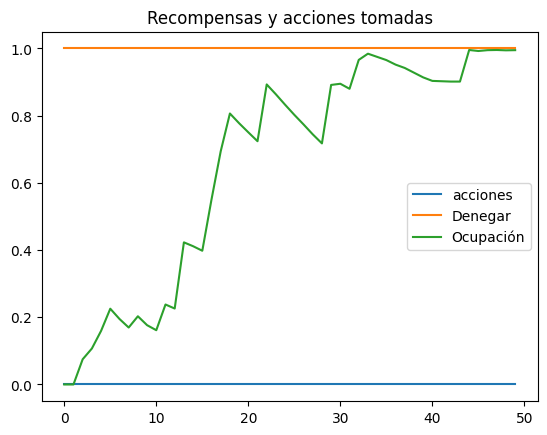

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, -28.649999999999995, 4.0, 4.0, 4.0, -37.3, -34.35, -31.25, -28.249999999999996, 4.0, 4.0, 4.0, -37.14999999999999, -37.5, -36.0, -44.599999999999994, -46.45, -45.5, -44.55, -43.199999999999996, -42.199999999999996, -40.800000000000004, -39.400000000000006, -38.349999999999994, -38.24999999999999, -38.14999999999999, -38.14999999999999, -47.550000000000004, -47.25, -47.5, -47.550000000000004, -47.45, -47.5]
0 50  0.0 1.0


In [8]:
assert len(acciones) == len(rewards)
#plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print(rewards)
num_permitidos=acciones.count(1)
print(num_permitidos,len(acciones)-num_permitidos,"",num_permitidos/len(acciones),1-num_permitidos/len(acciones))

[0.0, 0.0, 0.075, 0.107, 0.1595, 0.2255, 0.195, 0.1695, 0.203, 0.1765, 0.1615, 0.238, 0.226, 0.423, 0.4115, 0.398, 0.5505, 0.694, 0.8065, 0.7775, 0.7505, 0.724, 0.893, 0.8635, 0.8325, 0.8025, 0.774, 0.7445, 0.7175, 0.8915, 0.895, 0.88, 0.966, 0.9845, 0.975, 0.9655, 0.952, 0.942, 0.928, 0.914, 0.9035, 0.9025, 0.9015, 0.9015, 0.9955, 0.9925, 0.995, 0.9955, 0.9945, 0.995]


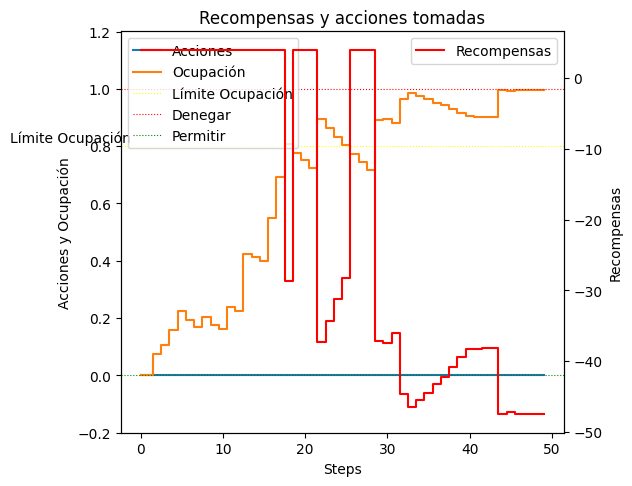

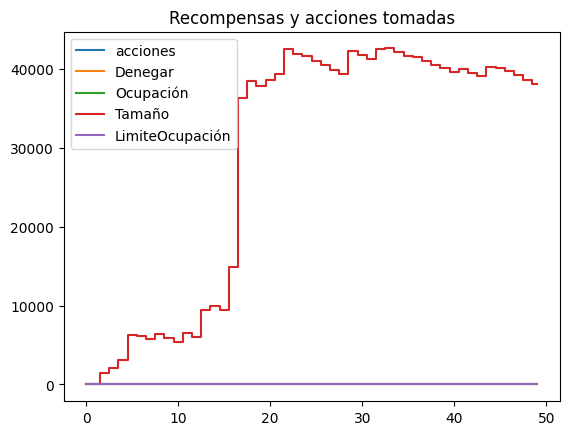

In [9]:
print(ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post')
#ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted', linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación', 
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5), 
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red', linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR), color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards, label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam=[x/10 for x in tams]


plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')

plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")

plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()

In [10]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'Estado

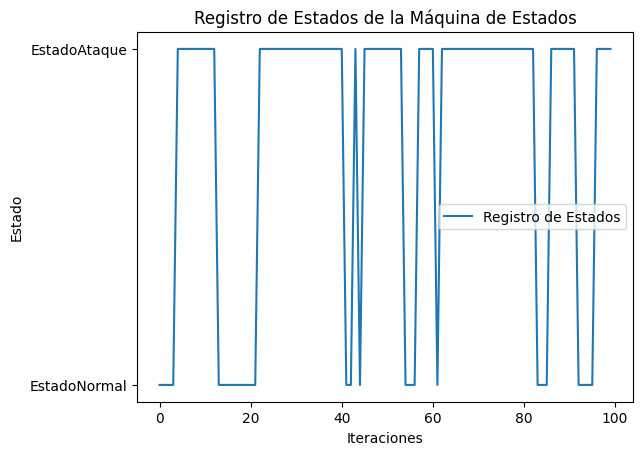

In [11]:
from __future__ import annotations

from abc import ABC, abstractmethod


class MaquinaDeEstados:
    def __init__(self, seed=10):
        self.estado: Estado = EstadoNormal
        self.estados_posibles: tuple[type[Estado]] = (
            EstadoNormal, 
            EstadoAtaque)
        self.registro_estados: list[Estado] = []
        self._np_random, self._np_random_seed = seeding.np_random(seed)

    def get_random(self):
        return self._np_random.random()

    def get_random_choice(self, choices):
        return self._np_random.choice(choices)

    def cambiar_estado(self):
        self.estado.cambiar(self)
        self.registro_estados.append(self.estado.__name__)


class Estado(ABC):
    @classmethod
    @abstractmethod
    def cambiar(cls, maquina: MaquinaDeEstados):
        """Método de clase que cambiará el estado"""
        if maquina.get_random() < cls.probCambiar():
            # Elegir aleatoriamente un nuevo estado diferente al actual
            new_state: Estado = maquina.get_random_choice(
                cls.get_estados_posibles(maquina.estados_posibles))
            maquina.estado = new_state

    @classmethod
    @abstractmethod
    def probCambiar(cls) -> float:
        """Método de clase que devuelve la probabilidad de cambio de estado"""
        pass

    @classmethod
    @abstractmethod
    @cache
    def get_estados_posibles(cls, estados) -> list[Estado]:
        """Método de clase que devuelve los estados posibles"""
        return list(set(estados).difference({cls}))


class EstadoNormal(Estado):
    @classmethod
    def probCambiar(cls):
        return 0.3


class EstadoAtaque(Estado):
    @classmethod
    def probCambiar(cls):
        return 0.1


maquina = MaquinaDeEstados(seed=101)
for _ in range(100):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [12]:
from itertools import product
import pandas as pd


# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {x: 0 for x in combinaciones_con_repeticion}

print(dict_con)

estado_Act = maquina.registro_estados[0]
for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Act, estado)] += 1
    estado_Act: Estado = estado

for estado1 in lista:
    total = 0
    for estado2 in lista:
        total += dict_con[(estado1, estado2)]
    for estado2 in lista:
        print(f"De {estado1} a {estado2}: {
              dict_con[(estado1, estado2)] / total:6.2%}")

{('EstadoNormal', 'EstadoNormal'): 0, ('EstadoNormal', 'EstadoAtaque'): 0, ('EstadoAtaque', 'EstadoNormal'): 0, ('EstadoAtaque', 'EstadoAtaque'): 0}
De EstadoNormal a EstadoNormal: 70.37%
De EstadoNormal a EstadoAtaque: 29.63%
De EstadoAtaque a EstadoNormal:  9.72%
De EstadoAtaque a EstadoAtaque: 90.28%


In [95]:
from typing import Any


class Packet_Generator():
    def __init__(self, min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_rate=3, max_rate=31,
                 seed=None):

        sizes: list[tuple[int, int]] = [
            (64, 128),
            (128, 256),
            (256, 1024),
            (1024, 1500)]
        probs: list[float] = [0.5,
                              0.2,
                              0.15,
                              0.15]
        assert np.sum(probs) == 1
        assert len(sizes) == len(probs)
        
        self._np_random,_=seeding.np_random(seed)
        indice: int = self._np_random.choice(len(sizes), p=probs)

        min_size, max_size = sizes[indice]

        self.packet = Dict({
            "IP":  Box(low=min_ip, high=max_ip, shape=(), dtype=int, 
                       seed=self._np_random),
            "PORT":  Box(low=min_port, high=max_port, shape=(), dtype=int, 
                         seed=self._np_random),
            "PROTOCOL":  Box(low=min_protocol, high=max_protocol, shape=(), dtype=int, 
                             seed=self._np_random),
            "SIZE":  Box(low=min_size, high=max_size, shape=(), dtype=int, 
                         seed=self._np_random)
        })

        self.min_rate: int = min_rate
        self.max_rate: int = max_rate

    def generate_packet(self) -> dict[str, int]:
        return self.packet.sample()

    def generate_packets(self) -> list[dict[str, int]]:
        num_packets: int = self._np_random.integers(self.min_rate, self.max_rate)
        return [self.generate_packet() for _ in range(num_packets)]
    
for i in range(1):
    a=Packet_Generator(seed=i)
    print(a.generate_packets())

[{'IP': 81, 'PORT': 66, 'PROTOCOL': 82, 'SIZE': 245}, {'IP': 1213, 'PORT': 2918, 'PROTOCOL': 54, 'SIZE': 248}, {'IP': 1632, 'PORT': 10, 'PROTOCOL': 86, 'SIZE': 132}, {'IP': 1460, 'PORT': 702, 'PROTOCOL': 87, 'SIZE': 197}, {'IP': 599, 'PORT': 1691, 'PROTOCOL': 2, 'SIZE': 144}, {'IP': 1341, 'PORT': 2589, 'PROTOCOL': 62, 'SIZE': 177}, {'IP': 1995, 'PORT': 3924, 'PROTOCOL': 69, 'SIZE': 211}, {'IP': 1377, 'PORT': 1556, 'PROTOCOL': 13, 'SIZE': 221}, {'IP': 1051, 'PORT': 1241, 'PROTOCOL': 49, 'SIZE': 242}, {'IP': 1869, 'PORT': 1431, 'PROTOCOL': 57, 'SIZE': 169}, {'IP': 1189, 'PORT': 1351, 'PROTOCOL': 39, 'SIZE': 242}, {'IP': 454, 'PORT': 2493, 'PROTOCOL': 8, 'SIZE': 235}, {'IP': 1574, 'PORT': 957, 'PROTOCOL': 88, 'SIZE': 135}, {'IP': 672, 'PORT': 601, 'PROTOCOL': 45, 'SIZE': 230}, {'IP': 461, 'PORT': 208, 'PROTOCOL': 40, 'SIZE': 153}, {'IP': 181, 'PORT': 2321, 'PROTOCOL': 30, 'SIZE': 214}, {'IP': 399, 'PORT': 3769, 'PROTOCOL': 36, 'SIZE': 141}]
